# SiPakMED Cervical Cell Classification Pipeline V2

A comprehensive pipeline for cervical cancer cell classification using:
- **Data Preprocessing**: NLM Denoising + CLAHE
- **Baseline Evaluation**: VGG, DenseNet, ResNet variants
- **Hybrid Model**: ResNet50 Feature Extractor + Logistic Classifier
- **Explainability**: SHAP Analysis
- **Deployment**: Streamlit Dashboard

---

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Setup and Imports

In [3]:
# Install required packages (uncomment if needed)
# !pip install torch torchvision scikit-learn shap matplotlib seaborn opencv-python pillow tqdm streamlit

In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# SHAP for explainability
import shap

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


## 2. Configuration

In [5]:
# Dataset configuration
CONFIG = {
    'data_dir': '/content/drive/MyDrive/6_Project Phoenix_Cervical Cancer Cell Classification/Preprocessed Datasets/Augmented Datasets/Augmented Dataset - Limited Enhancement',
    'classes': ['im_Dyskeratotic', 'im_Koilocytotic', 'im_Metaplastic', 'im_Parabasal', 'im_Superficial-Intermediate'],
    'class_names': ['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 'Parabasal', 'Superficial-Intermediate'],
    'subfolder': 'NLM_CLAHE',
    'img_size': 224,
    'batch_size': 32,
    'epochs': 10,
    'learning_rate': 0.001,
    'test_split': 0.2,
    'val_split': 0.1
}

## 3. Data Loading and Preprocessing

In [6]:
def load_dataset(config):
    """
    Load images from the dataset directory structure.
    Returns lists of image paths and corresponding labels.
    """
    image_paths = []
    labels = []

    for idx, class_folder in enumerate(config['classes']):
        class_path = os.path.join(config['data_dir'], class_folder, config['subfolder'])

        if not os.path.exists(class_path):
            print(f"Warning: Path not found - {class_path}")
            continue

        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.bmp', '.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_path, img_file))
                labels.append(idx)

    print(f"Loaded {len(image_paths)} images across {len(config['classes'])} classes")
    return image_paths, labels

# Load the dataset
image_paths, labels = load_dataset(CONFIG)

# Display class distribution
label_counts = pd.Series(labels).value_counts().sort_index()
print("\nClass Distribution:")
for idx, count in label_counts.items():
    print(f"  {CONFIG['class_names'][idx]}: {count}")

Loaded 4049 images across 5 classes

Class Distribution:
  Dyskeratotic: 813
  Koilocytotic: 825
  Metaplastic: 793
  Parabasal: 787
  Superficial-Intermediate: 831


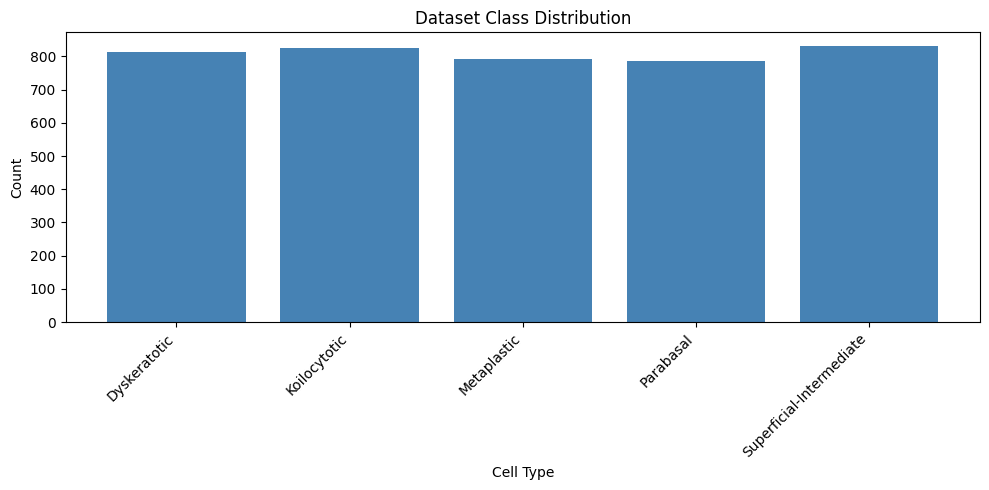

In [7]:
# Visualize class distribution
plt.figure(figsize=(10, 5))
plt.bar(CONFIG['class_names'], label_counts.values, color='steelblue')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.title('Dataset Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 3.1 Image Preprocessing Pipeline (NLM Denoising + CLAHE)

In [8]:
def apply_nlm_denoising(image, h=10, template_window=7, search_window=21):
    """
    Apply Non-Local Means Denoising to reduce noise while preserving edges.

    Args:
        image: Input BGR image
        h: Filter strength (higher = more denoising)
        template_window: Size of template patch
        search_window: Size of area to search for similar patches
    """
    return cv2.fastNlMeansDenoisingColored(image, None, h, h, template_window, search_window)


def apply_clahe(image, clip_limit=2.0, tile_size=(8, 8)):
    """
    Apply CLAHE (Contrast Limited Adaptive Histogram Equalization).
    Improves local contrast while limiting noise amplification.

    Args:
        image: Input BGR image
        clip_limit: Threshold for contrast limiting
        tile_size: Size of grid for histogram equalization
    """
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_size)
    l_clahe = clahe.apply(l)

    # Merge and convert back to BGR
    lab_clahe = cv2.merge([l_clahe, a, b])
    return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)


def preprocess_image(image_path, apply_preprocessing=True):
    """
    Load and preprocess a single image.
    """
    image = cv2.imread(image_path)

    if apply_preprocessing:
        image = apply_nlm_denoising(image)
        image = apply_clahe(image)

    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

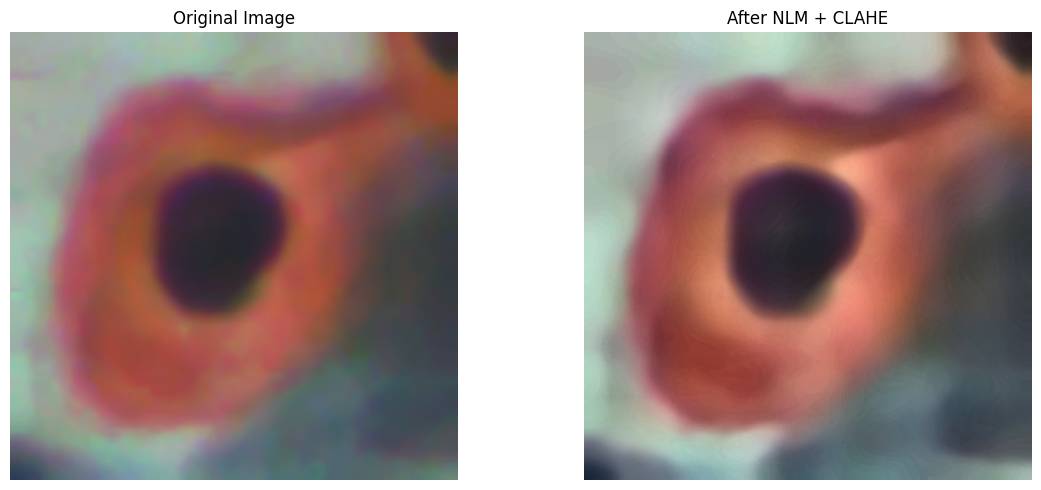

In [9]:
# Visualize preprocessing effect
if len(image_paths) > 0:
    sample_path = image_paths[0]

    # Load original and processed
    original = cv2.cvtColor(cv2.imread(sample_path), cv2.COLOR_BGR2RGB)
    processed = preprocess_image(sample_path, apply_preprocessing=True)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(processed)
    axes[1].set_title('After NLM + CLAHE')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

### 3.2 Custom Dataset and Data Augmentation

In [10]:
class CervicalCellDataset(Dataset):
    """
    Custom PyTorch Dataset for cervical cell images.
    """
    def __init__(self, image_paths, labels, transform=None, apply_preprocessing=False):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.apply_preprocessing = apply_preprocessing

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = preprocess_image(self.image_paths[idx], self.apply_preprocessing)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label


# Define transforms with data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test transform (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
# Split dataset into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    image_paths, labels, test_size=CONFIG['test_split'],
    stratify=labels, random_state=SEED
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=CONFIG['val_split'],
    stratify=y_train_val, random_state=SEED
)

print(f"Training set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Test set: {len(X_test)} images")

# Create datasets
train_dataset = CervicalCellDataset(X_train, y_train, train_transform, apply_preprocessing=False)
val_dataset = CervicalCellDataset(X_val, y_val, val_transform, apply_preprocessing=False)
test_dataset = CervicalCellDataset(X_test, y_test, val_transform, apply_preprocessing=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)

Training set: 2915 images
Validation set: 324 images
Test set: 810 images


## 4. Baseline Model Evaluation

Comparative analysis of pre-trained CNNs: VGG, DenseNet, and ResNet variants.

In [12]:
def create_model(model_name, num_classes, pretrained=True):
    """
    Create a pre-trained model with modified classifier for our number of classes.
    """
    if model_name == 'vgg16':
        model = models.vgg16(weights='IMAGENET1K_V1' if pretrained else None)
        model.classifier[6] = nn.Linear(4096, num_classes)

    elif model_name == 'vgg19':
        model = models.vgg19(weights='IMAGENET1K_V1' if pretrained else None)
        model.classifier[6] = nn.Linear(4096, num_classes)

    elif model_name == 'resnet18':
        model = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)
        model.fc = nn.Linear(512, num_classes)

    elif model_name == 'resnet34':
        model = models.resnet34(weights='IMAGENET1K_V1' if pretrained else None)
        model.fc = nn.Linear(512, num_classes)

    elif model_name == 'resnet50':
        model = models.resnet50(weights='IMAGENET1K_V1' if pretrained else None)
        model.fc = nn.Linear(2048, num_classes)

    elif model_name == 'densenet121':
        model = models.densenet121(weights='IMAGENET1K_V1' if pretrained else None)
        model.classifier = nn.Linear(1024, num_classes)

    elif model_name == 'densenet169':
        model = models.densenet169(weights='IMAGENET1K_V1' if pretrained else None)
        model.classifier = nn.Linear(1664, num_classes)

    else:
        raise ValueError(f"Unknown model: {model_name}")

    return model

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    """
    Train a model and return training history.
    """
    model = model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        # Calculate metrics
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total

        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc

    return model, history, best_val_acc

In [14]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate model on test set and return predictions.
    """
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy, all_preds, all_labels

In [15]:
# Baseline models to evaluate
baseline_models = ['vgg16', 'resnet18', 'resnet34', 'resnet50', 'densenet121']
num_classes = len(CONFIG['classes'])

# Store results
baseline_results = {}

print("="*60)
print("BASELINE MODEL EVALUATION")
print("="*60)

for model_name in baseline_models:
    print(f"\n--- Training {model_name.upper()} ---")

    # Create model
    model = create_model(model_name, num_classes)

    # Setup training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

    # Train model
    model, history, best_val_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer,
        CONFIG['epochs'], DEVICE
    )

    # Evaluate on test set
    test_acc, preds, labels_true = evaluate_model(model, test_loader, DEVICE)

    baseline_results[model_name] = {
        'model': model,
        'history': history,
        'val_acc': best_val_acc,
        'test_acc': test_acc * 100
    }

    print(f"{model_name.upper()} - Test Accuracy: {test_acc*100:.2f}%")

BASELINE MODEL EVALUATION

--- Training VGG16 ---
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 87.8MB/s]


Epoch 1: Train Acc: 21.27%, Val Acc: 28.40%


Epoch 2: Train Acc: 22.57%, Val Acc: 20.68%


Epoch 3: Train Acc: 19.59%, Val Acc: 20.06%


Epoch 4: Train Acc: 22.54%, Val Acc: 20.37%


Epoch 5: Train Acc: 20.45%, Val Acc: 20.37%


Epoch 6: Train Acc: 19.73%, Val Acc: 20.37%


Epoch 7: Train Acc: 20.51%, Val Acc: 19.44%


Epoch 8: Train Acc: 18.35%, Val Acc: 20.68%


Epoch 9: Train Acc: 20.72%, Val Acc: 19.44%


Epoch 10: Train Acc: 19.38%, Val Acc: 20.37%
VGG16 - Test Accuracy: 20.37%

--- Training RESNET18 ---
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


Epoch 1: Train Acc: 81.30%, Val Acc: 87.96%


Epoch 2: Train Acc: 88.51%, Val Acc: 84.88%


Epoch 3: Train Acc: 88.44%, Val Acc: 91.36%


Epoch 4: Train Acc: 90.15%, Val Acc: 83.33%


Epoch 5: Train Acc: 90.57%, Val Acc: 89.51%


Epoch 6: Train Acc: 92.32%, Val Acc: 88.89%


Epoch 7: Train Acc: 92.49%, Val Acc: 92.59%


Epoch 8: Train Acc: 91.70%, Val Acc: 92.59%


Epoch 9: Train Acc: 93.34%, Val Acc: 92.28%


Epoch 10: Train Acc: 92.62%, Val Acc: 90.74%
RESNET18 - Test Accuracy: 90.00%

--- Training RESNET34 ---
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 230MB/s]


Epoch 1: Train Acc: 78.28%, Val Acc: 66.98%


Epoch 2: Train Acc: 87.34%, Val Acc: 91.67%


Epoch 3: Train Acc: 87.34%, Val Acc: 94.44%


Epoch 4: Train Acc: 90.60%, Val Acc: 87.35%


Epoch 5: Train Acc: 90.02%, Val Acc: 91.98%


Epoch 6: Train Acc: 90.53%, Val Acc: 91.98%


Epoch 7: Train Acc: 92.08%, Val Acc: 91.98%


Epoch 8: Train Acc: 89.71%, Val Acc: 85.80%


Epoch 9: Train Acc: 88.78%, Val Acc: 93.52%


Epoch 10: Train Acc: 92.38%, Val Acc: 93.83%
RESNET34 - Test Accuracy: 94.20%

--- Training RESNET50 ---
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s]


Epoch 1: Train Acc: 73.04%, Val Acc: 83.64%


Epoch 2: Train Acc: 82.98%, Val Acc: 86.73%


Epoch 3: Train Acc: 86.35%, Val Acc: 85.80%


Epoch 4: Train Acc: 87.72%, Val Acc: 79.32%


Epoch 5: Train Acc: 87.10%, Val Acc: 87.04%


Epoch 6: Train Acc: 88.06%, Val Acc: 87.96%


Epoch 7: Train Acc: 90.29%, Val Acc: 91.98%


Epoch 8: Train Acc: 89.71%, Val Acc: 91.67%


Epoch 9: Train Acc: 92.49%, Val Acc: 84.26%


Epoch 10: Train Acc: 92.73%, Val Acc: 93.52%
RESNET50 - Test Accuracy: 91.98%

--- Training DENSENET121 ---
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 235MB/s]


Epoch 1: Train Acc: 82.92%, Val Acc: 92.28%


Epoch 2: Train Acc: 88.13%, Val Acc: 87.04%


Epoch 3: Train Acc: 90.53%, Val Acc: 86.73%


Epoch 4: Train Acc: 90.57%, Val Acc: 87.04%


Epoch 5: Train Acc: 92.25%, Val Acc: 94.14%


Epoch 6: Train Acc: 93.17%, Val Acc: 95.06%


Epoch 7: Train Acc: 94.65%, Val Acc: 91.36%


Epoch 8: Train Acc: 91.94%, Val Acc: 94.14%


Epoch 9: Train Acc: 94.20%, Val Acc: 95.37%


Epoch 10: Train Acc: 94.03%, Val Acc: 92.28%
DENSENET121 - Test Accuracy: 94.94%


In [16]:
# Compare baseline results
print("\n" + "="*60)
print("BASELINE RESULTS SUMMARY")
print("="*60)

results_df = pd.DataFrame({
    'Model': baseline_results.keys(),
    'Validation Acc (%)': [r['val_acc'] for r in baseline_results.values()],
    'Test Acc (%)': [r['test_acc'] for r in baseline_results.values()]
})
results_df = results_df.sort_values('Test Acc (%)', ascending=False)
print(results_df.to_string(index=False))

# Identify best model
best_model_name = results_df.iloc[0]['Model']
print(f"\nBest Baseline Model: {best_model_name.upper()}")


BASELINE RESULTS SUMMARY
      Model  Validation Acc (%)  Test Acc (%)
densenet121           95.370370     94.938272
   resnet34           94.444444     94.197531
   resnet50           93.518519     91.975309
   resnet18           92.592593     90.000000
      vgg16           28.395062     20.370370

Best Baseline Model: DENSENET121


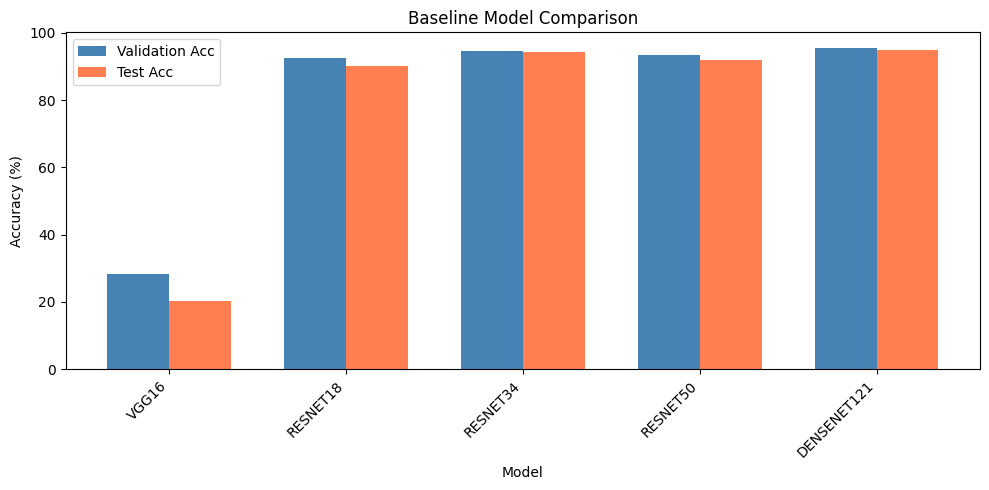

In [17]:
# Visualize baseline comparison
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(baseline_results))
width = 0.35

models = list(baseline_results.keys())
val_accs = [baseline_results[m]['val_acc'] for m in models]
test_accs = [baseline_results[m]['test_acc'] for m in models]

ax.bar(x - width/2, val_accs, width, label='Validation Acc', color='steelblue')
ax.bar(x + width/2, test_accs, width, label='Test Acc', color='coral')

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Baseline Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in models], rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

## 5. Hybrid Model Implementation

Using ResNet50 as a fixed feature extractor + Logistic Regression classifier.

In [29]:
class FeatureExtractor(nn.Module):
    """
    ResNet50 as a fixed feature extractor.
    Removes the final classification layer to output feature vectors.
    """
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        # Use the fully qualified name to avoid conflict with a potentially shadowed 'models' variable
        resnet = torchvision.models.resnet50(weights='IMAGENET1K_V1')
        # Remove the final fully connected layer
        self.features = nn.Sequential(*list(resnet.children())[:-1])

        # Freeze all layers
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Output: (batch_size, 2048)
        return x


# Create feature extractor
feature_extractor = FeatureExtractor().to(DEVICE)
feature_extractor.eval()
print("ResNet50 Feature Extractor created (2048-dim output)")

ResNet50 Feature Extractor created (2048-dim output)


In [22]:
def extract_features(feature_extractor, data_loader, device):
    """
    Extract features from all images using the feature extractor.
    """
    features_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Extracting features"):
            images = images.to(device)
            features = feature_extractor(images)
            features_list.append(features.cpu().numpy())
            labels_list.extend(labels.numpy())

    return np.vstack(features_list), np.array(labels_list)


# Extract features from all datasets
print("\nExtracting features from training set...")
X_train_features, y_train_labels = extract_features(feature_extractor, train_loader, DEVICE)

print("Extracting features from validation set...")
X_val_features, y_val_labels = extract_features(feature_extractor, val_loader, DEVICE)

print("Extracting features from test set...")
X_test_features, y_test_labels = extract_features(feature_extractor, test_loader, DEVICE)

print(f"\nFeature shapes:")
print(f"  Train: {X_train_features.shape}")
print(f"  Val: {X_val_features.shape}")
print(f"  Test: {X_test_features.shape}")


Extracting features from training set...


Extracting features: 100%|██████████| 92/92 [00:30<00:00,  3.03it/s]


Extracting features from validation set...


Extracting features: 100%|██████████| 11/11 [00:02<00:00,  3.77it/s]


Extracting features from test set...


Extracting features: 100%|██████████| 26/26 [00:07<00:00,  3.62it/s]


Feature shapes:
  Train: (2915, 2048)
  Val: (324, 2048)
  Test: (810, 2048)


In [23]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_val_scaled = scaler.transform(X_val_features)
X_test_scaled = scaler.transform(X_test_features)

# Train Logistic Regression classifier
print("\nTraining Logistic Regression classifier...")
logistic_classifier = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    random_state=SEED,
    C=1.0
)

logistic_classifier.fit(X_train_scaled, y_train_labels)
print("Training complete!")


Training Logistic Regression classifier...
Training complete!


In [24]:
# Evaluate hybrid model
train_pred = logistic_classifier.predict(X_train_scaled)
val_pred = logistic_classifier.predict(X_val_scaled)
test_pred = logistic_classifier.predict(X_test_scaled)

train_acc = accuracy_score(y_train_labels, train_pred) * 100
val_acc = accuracy_score(y_val_labels, val_pred) * 100
test_acc = accuracy_score(y_test_labels, test_pred) * 100

print("\n" + "="*60)
print("HYBRID MODEL RESULTS (ResNet50 + Logistic Regression)")
print("="*60)
print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Validation Accuracy: {val_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")


HYBRID MODEL RESULTS (ResNet50 + Logistic Regression)
Training Accuracy: 100.00%
Validation Accuracy: 87.35%
Test Accuracy: 88.02%



Classification Report:
                          precision    recall  f1-score   support

            Dyskeratotic       0.91      0.97      0.94       163
            Koilocytotic       0.90      0.73      0.81       165
             Metaplastic       0.74      0.90      0.81       159
               Parabasal       0.98      0.85      0.91       157
Superficial-Intermediate       0.91      0.96      0.94       166

                accuracy                           0.88       810
               macro avg       0.89      0.88      0.88       810
            weighted avg       0.89      0.88      0.88       810



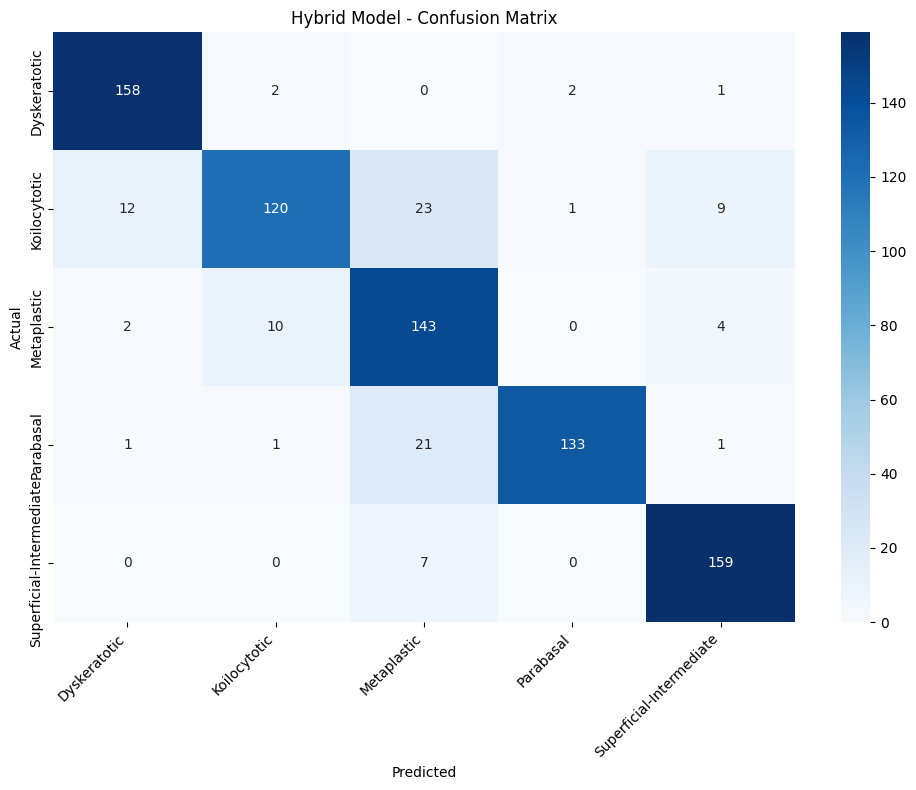

In [25]:
# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_labels, test_pred, target_names=CONFIG['class_names']))

# Confusion matrix
cm = confusion_matrix(y_test_labels, test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CONFIG['class_names'],
            yticklabels=CONFIG['class_names'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Hybrid Model - Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 6. Final Comparison: Baseline vs Hybrid


FINAL MODEL COMPARISON
               Model  Test Accuracy (%)
         densenet121          94.938272
            resnet34          94.197531
            resnet50          91.975309
            resnet18          90.000000
Hybrid (ResNet50+LR)          88.024691
               vgg16          20.370370


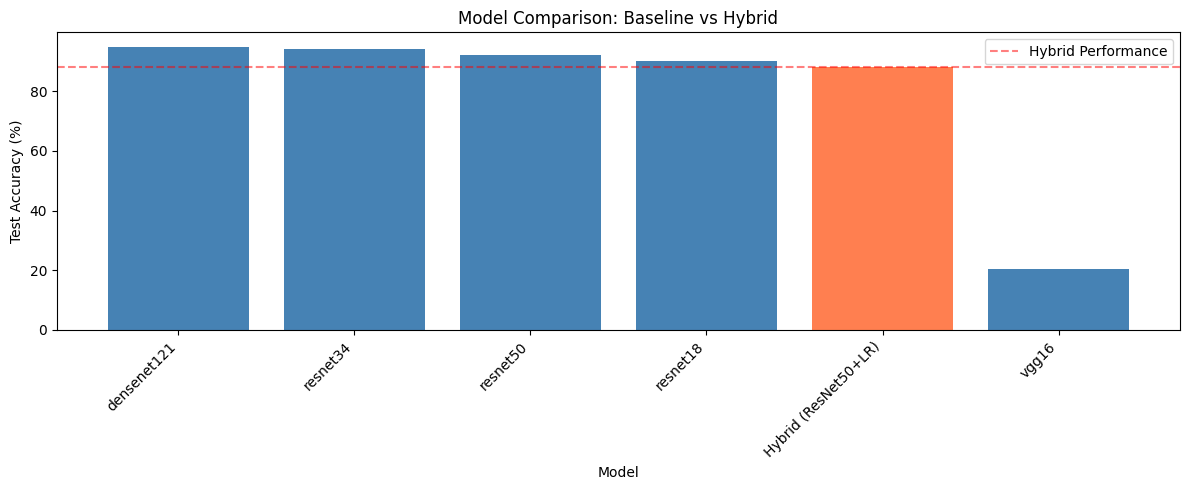

In [26]:
print("\n" + "="*60)
print("FINAL MODEL COMPARISON")
print("="*60)

# Add hybrid results
comparison_data = {
    'Model': list(baseline_results.keys()) + ['Hybrid (ResNet50+LR)'],
    'Test Accuracy (%)': [baseline_results[m]['test_acc'] for m in baseline_results] + [test_acc]
}

comparison_df = pd.DataFrame(comparison_data).sort_values('Test Accuracy (%)', ascending=False)
print(comparison_df.to_string(index=False))

# Visualize
plt.figure(figsize=(12, 5))
colors = ['coral' if 'Hybrid' in m else 'steelblue' for m in comparison_df['Model']]
plt.bar(comparison_df['Model'], comparison_df['Test Accuracy (%)'], color=colors)
plt.xlabel('Model')
plt.ylabel('Test Accuracy (%)')
plt.title('Model Comparison: Baseline vs Hybrid')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=test_acc, color='red', linestyle='--', alpha=0.5, label='Hybrid Performance')
plt.legend()
plt.tight_layout()
plt.show()

## 7. Explainability with SHAP

In [27]:
print("\n" + "="*60)
print("SHAP EXPLAINABILITY ANALYSIS")
print("="*60)

# Use a subset for SHAP analysis (SHAP can be slow with large datasets)
n_background = min(100, len(X_train_scaled))
n_explain = min(50, len(X_test_scaled))

background = X_train_scaled[:n_background]
X_explain = X_test_scaled[:n_explain]

# Create SHAP explainer
print("\nCreating SHAP explainer (this may take a moment)...")
explainer = shap.LinearExplainer(logistic_classifier, background)

# Calculate SHAP values
print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_explain)


SHAP EXPLAINABILITY ANALYSIS

Creating SHAP explainer (this may take a moment)...
Calculating SHAP values...


In [30]:
# Feature importance summary (mean absolute SHAP values per class)
print("\nTop 20 Most Important Features (by mean |SHAP|):")

# For multiclass, shap_values is a list of arrays (one per class)
if isinstance(shap_values, list):
    # This case is for when shap_values is a list of (n_explain, n_features) arrays
    # Averaging over explanations (axis=0) for each class, then averaging across classes
    mean_shap = np.mean([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)
else:
    # This case is for when shap_values is a single (n_explain, n_features, n_classes) array
    # Averaging over explanations (axis=0) and classes (axis=2)
    mean_shap = np.abs(shap_values).mean(axis=(0, 2)) # Corrected to average over examples and classes

# Get top features
top_indices = np.argsort(mean_shap)[-20:][::-1]
for i, idx in enumerate(top_indices[:10]):
    print(f"  Feature {idx}: {mean_shap[idx]:.4f}")


Top 20 Most Important Features (by mean |SHAP|):
  Feature 2043: 0.2507
  Feature 1389: 0.2430
  Feature 135: 0.2238
  Feature 1900: 0.2184
  Feature 875: 0.2058
  Feature 740: 0.2018
  Feature 1060: 0.1954
  Feature 279: 0.1918
  Feature 624: 0.1916
  Feature 563: 0.1850


<Figure size 1200x600 with 0 Axes>

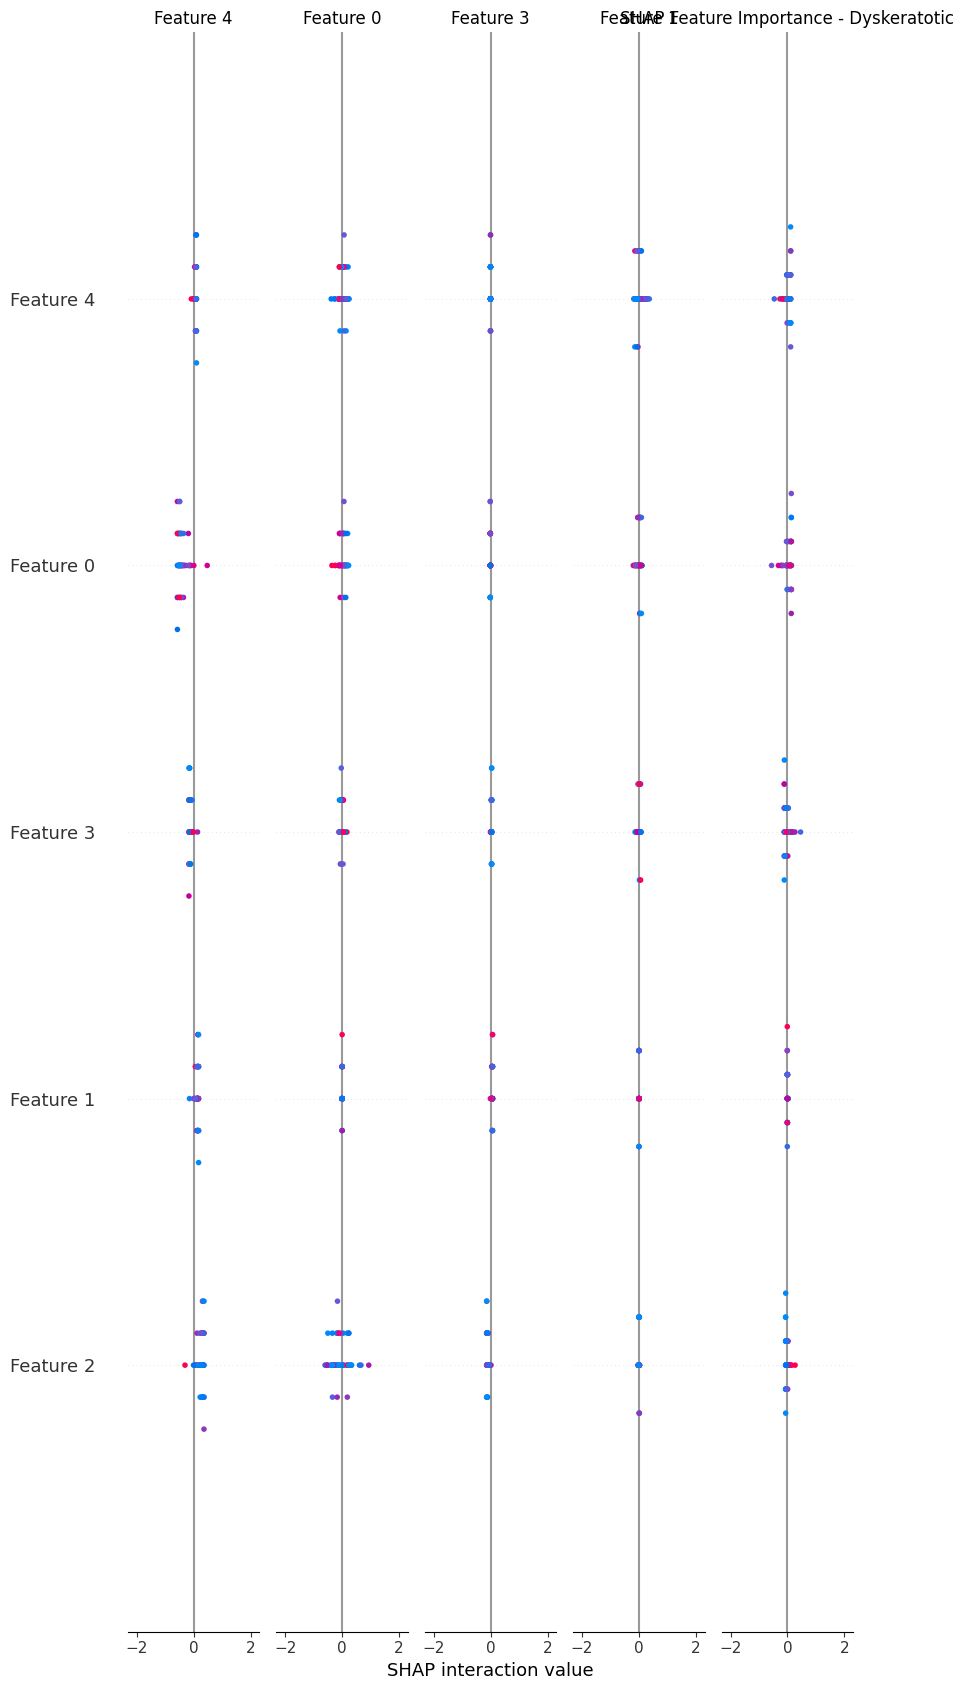

In [31]:
# SHAP summary plot for one class
plt.figure(figsize=(12, 6))
if isinstance(shap_values, list):
    # Plot for class 0
    shap.summary_plot(shap_values[0], X_explain, max_display=20, show=False)
else:
    shap.summary_plot(shap_values, X_explain, max_display=20, show=False)
plt.title(f'SHAP Feature Importance - {CONFIG["class_names"][0]}')
plt.tight_layout()
plt.show()

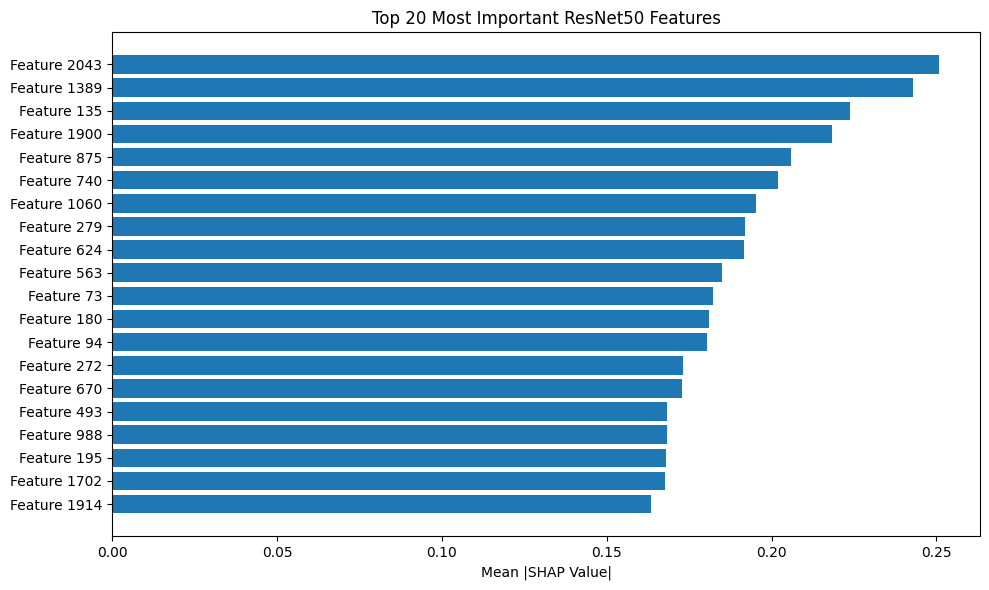

In [32]:
# Bar plot of feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(20), mean_shap[top_indices[:20]][::-1])
plt.yticks(range(20), [f'Feature {i}' for i in top_indices[:20][::-1]])
plt.xlabel('Mean |SHAP Value|')
plt.title('Top 20 Most Important ResNet50 Features')
plt.tight_layout()
plt.show()

## 8. Save Models and Artifacts

In [33]:
import pickle

# Create models directory
os.makedirs('models', exist_ok=True)

# Save feature extractor
torch.save(feature_extractor.state_dict(), 'models/resnet50_feature_extractor.pth')
print("Saved: models/resnet50_feature_extractor.pth")

# Save logistic classifier
with open('models/logistic_classifier.pkl', 'wb') as f:
    pickle.dump(logistic_classifier, f)
print("Saved: models/logistic_classifier.pkl")

# Save scaler
with open('models/feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Saved: models/feature_scaler.pkl")

# Save config
with open('models/config.pkl', 'wb') as f:
    pickle.dump(CONFIG, f)
print("Saved: models/config.pkl")

print("\nAll models saved successfully!")

Saved: models/resnet50_feature_extractor.pth
Saved: models/logistic_classifier.pkl
Saved: models/feature_scaler.pkl
Saved: models/config.pkl

All models saved successfully!


## 9. Streamlit Dashboard

Run the cell below to create the Streamlit app file, then execute:
```bash
streamlit run streamlit_app.py
```

In [34]:
streamlit_code = '''
"""
SiPakMED Cervical Cell Classification Dashboard
Run with: streamlit run streamlit_app.py
"""
import streamlit as st
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt

# Page configuration
st.set_page_config(
    page_title="SiPakMED Cell Classifier",
    page_icon="🔬",
    layout="wide"
)

# Constants
CLASS_NAMES = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]
IMG_SIZE = 224

# Feature extractor class
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        resnet = models.resnet50(weights=None)
        self.features = nn.Sequential(*list(resnet.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x

# Preprocessing functions
def apply_nlm_denoising(image):
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge([l_clahe, a, b])
    return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

@st.cache_resource
def load_models():
    """Load all required models."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load feature extractor
    feature_extractor = FeatureExtractor()
    feature_extractor.load_state_dict(torch.load("models/resnet50_feature_extractor.pth", map_location=device))
    feature_extractor.to(device)
    feature_extractor.eval()

    # Load classifier and scaler
    with open("models/logistic_classifier.pkl", "rb") as f:
        classifier = pickle.load(f)
    with open("models/feature_scaler.pkl", "rb") as f:
        scaler = pickle.load(f)

    return feature_extractor, classifier, scaler, device

def predict(image, feature_extractor, classifier, scaler, device, apply_preprocessing=True):
    """Make prediction on an image."""
    # Preprocessing
    img_array = np.array(image)
    if len(img_array.shape) == 2:
        img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
    elif img_array.shape[2] == 4:
        img_array = cv2.cvtColor(img_array, cv2.COLOR_RGBA2RGB)

    img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)

    if apply_preprocessing:
        img_bgr = apply_nlm_denoising(img_bgr)
        img_bgr = apply_clahe(img_bgr)

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    processed_image = Image.fromarray(img_rgb)

    # Transform
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(processed_image).unsqueeze(0).to(device)

    # Extract features
    with torch.no_grad():
        features = feature_extractor(img_tensor)

    # Scale and predict
    features_np = features.cpu().numpy()
    features_scaled = scaler.transform(features_np)

    prediction = classifier.predict(features_scaled)[0]
    probabilities = classifier.predict_proba(features_scaled)[0]

    return prediction, probabilities, processed_image

# Main app
def main():
    st.title("🔬 SiPakMED Cervical Cell Classifier")
    st.markdown("**Hybrid Model: ResNet50 Feature Extractor + Logistic Regression**")
    st.markdown("---")

    # Sidebar
    st.sidebar.header("Settings")
    apply_preprocessing = st.sidebar.checkbox("Apply NLM + CLAHE preprocessing", value=True)

    st.sidebar.markdown("---")
    st.sidebar.header("About")
    st.sidebar.info(
        "This dashboard classifies cervical cell images into 5 categories:\\n"
        "- Dyskeratotic\\n"
        "- Koilocytotic\\n"
        "- Metaplastic\\n"
        "- Parabasal\\n"
        "- Superficial-Intermediate"
    )

    # Load models
    try:
        feature_extractor, classifier, scaler, device = load_models()
        st.success(f"Models loaded successfully! (Device: {device})")
    except Exception as e:
        st.error(f"Error loading models: {e}")
        st.info("Please ensure model files exist in the \'models\' directory.")
        return

    # File uploader
    uploaded_file = st.file_uploader(
        "Upload a cervical cell image",
        type=["bmp", "png", "jpg", "jpeg"]
    )

    if uploaded_file is not None:
        image = Image.open(uploaded_file)

        col1, col2 = st.columns(2)

        with col1:
            st.subheader("Original Image")
            st.image(image, use_container_width=True)

        # Make prediction
        with st.spinner("Analyzing image..."):
            prediction, probabilities, processed = predict(
                image, feature_extractor, classifier, scaler, device, apply_preprocessing
            )

        with col2:
            st.subheader("Processed Image")
            st.image(processed, use_container_width=True)

        # Results
        st.markdown("---")
        st.subheader("Classification Results")

        predicted_class = CLASS_NAMES[prediction]
        confidence = probabilities[prediction] * 100

        st.success(f"**Predicted Class:** {predicted_class}")
        st.info(f"**Confidence:** {confidence:.2f}%")

        # Probability chart
        st.subheader("Class Probabilities")
        fig, ax = plt.subplots(figsize=(10, 4))
        colors = ["#ff6b6b" if i == prediction else "#4dabf7" for i in range(len(CLASS_NAMES))]
        ax.barh(CLASS_NAMES, probabilities * 100, color=colors)
        ax.set_xlabel("Probability (%)")
        ax.set_xlim(0, 100)
        for i, v in enumerate(probabilities * 100):
            ax.text(v + 1, i, f"{v:.1f}%", va="center")
        plt.tight_layout()
        st.pyplot(fig)

if __name__ == "__main__":
    main()
'''

# Write the Streamlit app
with open('streamlit_app.py', 'w') as f:
    f.write(streamlit_code)

print("Streamlit app saved to: streamlit_app.py")
print("\nTo run the dashboard:")
print("  cd 'SiPakMED Pipeline V2'")
print("  streamlit run streamlit_app.py")

Streamlit app saved to: streamlit_app.py

To run the dashboard:
  cd 'SiPakMED Pipeline V2'
  streamlit run streamlit_app.py


## 10. Summary

### Pipeline Components:

1. **Data Preprocessing**: NLM Denoising + CLAHE for image enhancement
2. **Data Augmentation**: Rotation, flipping, color jitter
3. **Baseline Evaluation**: Compared VGG16, ResNet18/34/50, DenseNet121
4. **Hybrid Model**: ResNet50 (frozen) + Logistic Regression
5. **Explainability**: SHAP analysis for feature importance
6. **Deployment**: Streamlit dashboard for inference

### Key Findings:
- The hybrid approach reduces overfitting by using a low-parameter classifier
- ResNet50 provides rich, transferable features (2048-dim)
- SHAP values reveal which features drive predictions

### Files Generated:
- `models/resnet50_feature_extractor.pth`
- `models/logistic_classifier.pkl`
- `models/feature_scaler.pkl`
- `models/config.pkl`
- `streamlit_app.py`